• **DOMAIN**: Botanical research

• **CONTEXT**: University X is currently undergoing some research involving understanding the characteristics of plant and plant seedlings at various stages of growth. They already have have invested on curating sample
images. They require an automation which can create a classifier capable of determining a plant's species from a photo

• **DATA DESCRIPTION**: The dataset comprises of images from 12 plant species. Source: https://www.kaggle.com/c/plant-seedlings-classification/data

• **PROJECT OBJECTIVE**: University’s management require an automation which can create a classifier capable of determining a plant's species from a photo

#### **Loading the Dataset**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
project_path = "/content/drive/MyDrive/AIML/Computer Vision/"

#### Extracting the Data

In [3]:
from zipfile import ZipFile
with ZipFile(project_path+'train.zip', 'r') as z:
  z.extractall()

#### Importing the necessary Libraries

In [4]:
import cv2
import os
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn import svm, metrics
from natsort import natsorted
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
%matplotlib inline
import glob
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
# from sklearn.grid_search import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve, GridSearchCV

In this dataset, the images of 12 different plant species are placed in different folders. The names of these folders are the labels of their species respectively. In the next step, we will use glob() function to iterate through all the folders and extract their labels.

In [5]:
paths = glob.glob("train/*")
label_names = [os.path.split(x)[-1] for x in paths]

print("Total labels: {}".format(len(label_names)))
print("Labels: {}".format(label_names))

Total labels: 12
Labels: ['Fat Hen', 'Black-grass', 'Common wheat', 'Sugar beet', 'Shepherds Purse', 'Maize', 'Charlock', 'Small-flowered Cranesbill', 'Common Chickweed', 'Loose Silky-bent', 'Scentless Mayweed', 'Cleavers']


We have also saved the names of the species in the 'label_names' variable.

#### Exploring Data
Now, let's explore the images to see how they look, their shape, size, colors, and so on. Firstly, we will view the images of all the 12 different plant species.

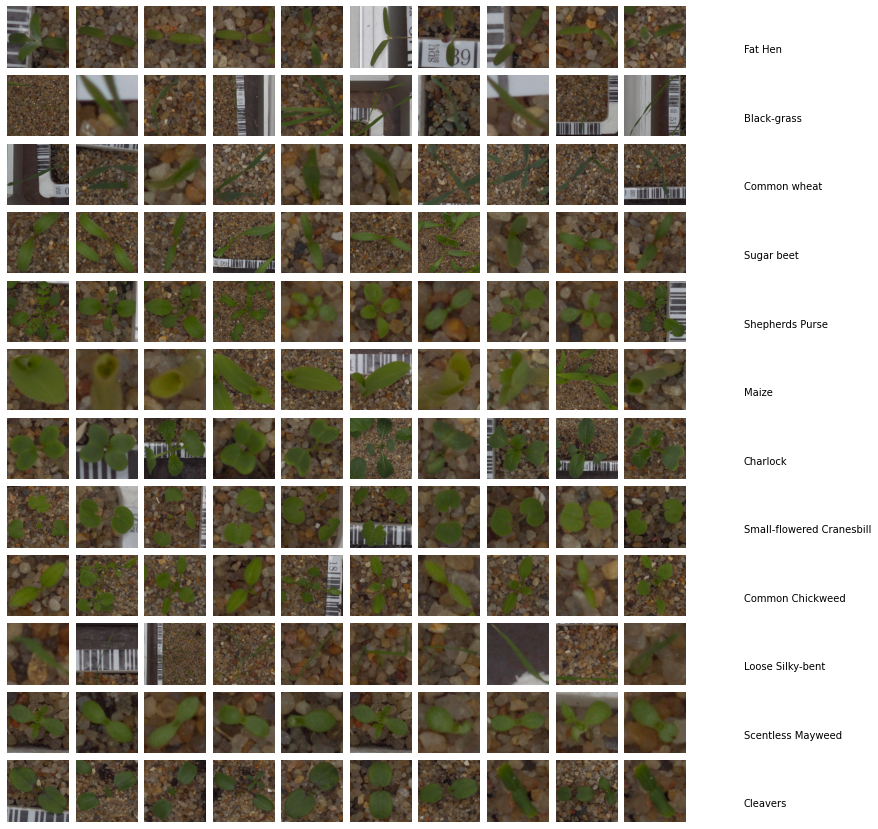

In [6]:
fig = plt.figure(1, (20, 15))
grid = ImageGrid(fig, 111, nrows_ncols=(12, 10), axes_pad=0.1)

n_img_class = []
counter = 0
for idx, label in enumerate(label_names):
    paths = glob.glob(os.path.join("train", label, "*.png"))
    n_img_class.append([label, len(paths)])
    perm = np.random.choice(len(paths), size=10)

    title = True
    for ii in perm:
        ax = grid[counter]
        if title:
            ax.text(1800, 105, label, verticalalignment="center")
            title = False
        img = cv2.imread(paths[ii])
        img = cv2.resize(img, (150, 150))
        ax.axis("off")
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        counter += 1
        
plt.show()

Most of the species look similar and seems difficult to classify by humans. Let's see how machines can do this easily.

Before, we proceed further, it's important to know the dimensions of these images. When working with OpenCV Python, images are stored in numpy ndarray. To get the image shape or size, we use ndarray.shape to get the dimensions of the image.

In [7]:
img.shape

(150, 150, 3)

The first two dimensions are the width and height of the images which are 150 each respectively. The third dimension refers to the channels of the images. Here, '3' refers to three channels - red, green and blue. These images are RGB images and are colored. For monochrome images, the number of channels is 1.

**Reading Images**

In this step, we store the labels of the species in a variable, and their respective images into an array, in a manner which machines can understand.

In [8]:
#save the path into variable to use it easily next times.
TRAIN_FOLDER= "train"

In [9]:
from glob import glob
images = []
classes=[]
missing=0
for class_folder_name in os.listdir(TRAIN_FOLDER):
    class_folder_path = os.path.join(TRAIN_FOLDER, class_folder_name)
    class_label = class_folder_name
    
    for image_path in glob(os.path.join(class_folder_path, "*.png")):
        image_bgr = cv2.imread(image_path, cv2.IMREAD_COLOR)
        if image_bgr is None: # if the file contain any missing value ignore it
          missing += 1
          continue
        images.append(image_bgr)
        
        classes.append(class_label)

Now, let's find the total number of images in our dataset.

In [10]:
print(f"Total no. of Images : {len(images)}")

Total no. of Images : 4767


#### **Resizing images**
Some images captured by a camera and fed to our AI algorithm vary in size, therefore, we should establish a base size for all images fed into our AI algorithms by resizing them.

In [11]:
# resize image
def resize_images(img):

  img = np.array(img).astype(np.uint8)
  #print(img.dtype)
  res = cv2.resize(img,(256,256), interpolation = cv2.INTER_CUBIC)
  return res

#save resized images into images.
images = [resize_images(img) for img in images]

Now, we have resized all the images with width and height as 250 each.

In [12]:
images[0].shape

(256, 256, 3)

In [13]:
#see number of images in each label
images = np.array(images)
classes = np.array(classes)
print("images shape: ", images.shape)
print("classes shape: ", classes.shape)

images shape:  (4767, 256, 256, 3)
classes shape:  (4767,)


As the 'classes' are nothing but labels of the species, they are of only 1 dimension, whereas 'images' contains colored images, hence its dimension is 3.

**Viewing the distribution of number of images in each class**

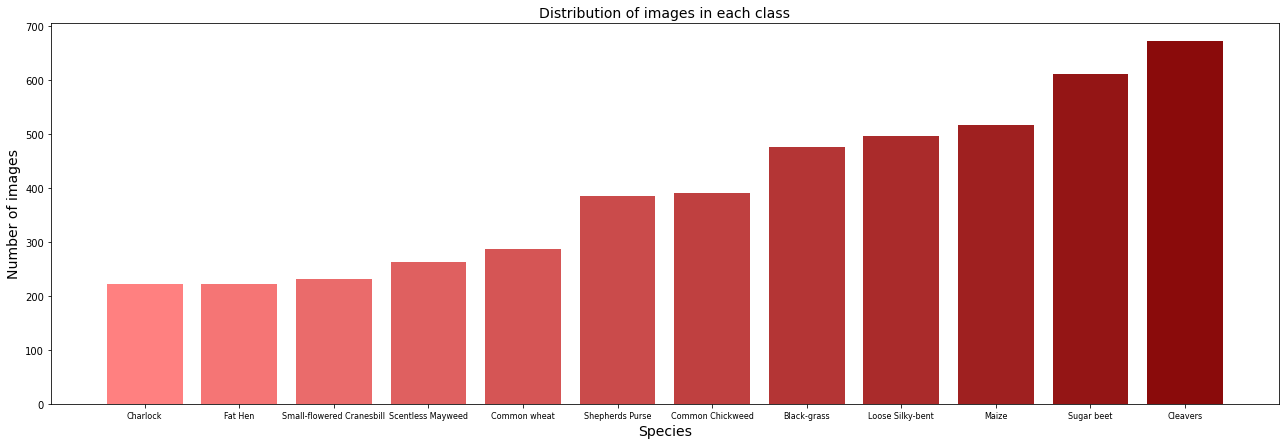

In [14]:
values =[]
labels=[]
for label in set(classes):
  values.append(len(images[classes == label]))
  labels.append(label)

values.sort()

code=np.arange(0,13,1)
data_normalizer = mp.colors.Normalize()
color_map = mp.colors.LinearSegmentedColormap(
    "my_map",
    {
        "red": [(0, 1.0, 1.0),
                (1.0, .5, .5)],
        "green": [(0, 0.5, 0.5),
                  (1.0, 0, 0)],
        "blue": [(0, 0.50, 0.5),
                 (1.0, 0, 0)]
    }
)

fig, ax = plt.subplots(figsize=(22,7))
ax.bar(labels, values, color=color_map(data_normalizer(code)))
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 10)
plt.xlabel("Species", fontsize = 14)
plt.ylabel("Number of images", fontsize = 14)
plt.title("Distribution of images in each class", fontsize=14)
plt.show()

Not all the species have equal number of images. The plant species 'Common Chickweed' has the highest number of images ranging between 650-680 images roughly. Whereas, the 'Charlock' plant species has the least number of images with around 220 images. The dataset is imbalanced.

Viewing random images

- Viewing images using index

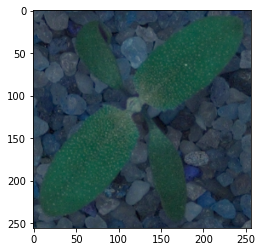

In [15]:
plt.imshow(images[50])

- Viewing images using a label name

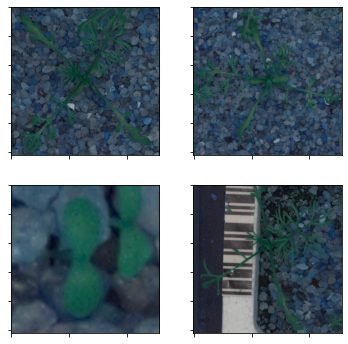

In [16]:
def plot_for_class(label):
    nb_rows = 2
    nb_cols = 2
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(6, 6))
    class_images =images[classes== label]
    n = 0
    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            axs[i, j].xaxis.set_ticklabels([])
            axs[i, j].yaxis.set_ticklabels([])
            axs[i, j].imshow(class_images[n])
            n += 1 
plot_for_class("Scentless Mayweed")

- Viewing images using an image name

In [17]:
#!ls "train/Scentless Mayweed" 1300c3cd9.png

img = cv2.imread("train/Scentless Mayweed/1300c3cd9.png")

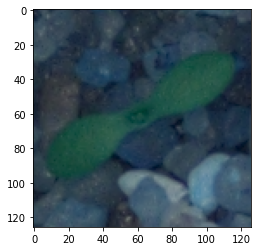

In [18]:
plt.imshow(img)

# **Image Classification**

Structure of an Image Classification Task

---


1.   Image Preprocessing - The aim of this process is to improve the image data
(features) by suppressing unwanted distortions and enhancement of some important image features so that our Computer Vision models can benefit from this improved data to work on.
2.   Detection of an object - Detection refers to the localization of an object which means the segmentation of the image and identifying the position of the object of interest.
3. Feature extraction and Training- This is a crucial step wherein statistical or deep learning methods are used to identify the most interesting patterns of the image, features that might be unique to a particular class and that will, later on, help the model to differentiate between different classes. This process where the model learns the features from the dataset is called model training.
4. Classification of the object - This step categorizes detected objects into predefined classes by using a suitable classification technique that compares the image patterns with the target patterns.

# *Image Preprocessing*

Pre-processing is a common name for operations with images at the lowest level of abstraction — both input and output are intensity images.

Need for Image-Preprocessing:

---


Computers are able to perform computations on numbers and is unable to interpret images in the way that we do. We have to somehow convert the images to numbers for the computer to understand.
The aim of pre-processing is an improvement of the image data that suppresses unwilling distortions or enhances some image features important for further processing.

- **Converting images from RGB to HSV and applying mophological transformations**

In [19]:
def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    sensitivity = 35
    lower_hsv = np.array([60 - sensitivity, 100, 50])
    upper_hsv = np.array([60 + sensitivity, 255, 255])

    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

- **Applying Segmentation**

In [20]:
def segment_plant(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output

- **Applying Sharpening**

In [21]:
def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

In [22]:
# Combining all functions

def preprocess(img):
  image_segmented = segment_plant(img)
  image_sharpen = sharpen_image(image_segmented)
  return image_sharpen

for indx, image in enumerate(images):
  try:
    images[indx] = preprocess(image)
      
  except:
    print(indx)
    continue

**Viewing the pre-processed images**

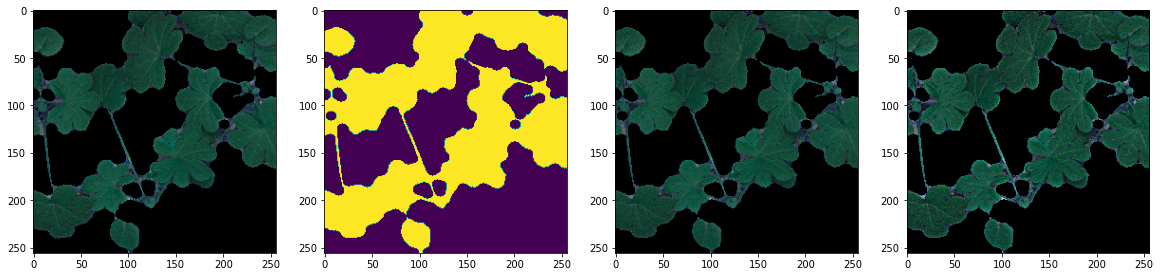

In [23]:
images = np.array(images)
classes = np.array(classes)
image = images[classes == "Small-flowered Cranesbill"][40]

image_mask = create_mask_for_plant(image)
image_segmented = segment_plant(image)
image_sharpen = sharpen_image(image_segmented)

fig, axs = plt.subplots(1, 4, figsize=(20, 20))
axs[0].imshow(image)
axs[1].imshow(image_mask)
axs[2].imshow(image_segmented)
axs[3].imshow(image_sharpen)

The first image is the original one, the second image is masked images, the third image is segmented, and the fourth one is sharpened.

## Data Preprocessing
Before we begin the data modelling, let's do the following tasks:

- Create a dataframe that records the models' performance metrics.

- Load the test image for prediction

- Encode the label names

- Train-test split the images for modelling

**Creating a dataframe to record models' performance metrics**

In [24]:
model_performance = pd.DataFrame(columns=['Model', 'Accuracy', 'Loss','Predicted Class'])

In [25]:
number_of_columns = images[1].shape[0] * images[1].shape[1]
print(number_of_columns)

65536


**Reading the image to predict**

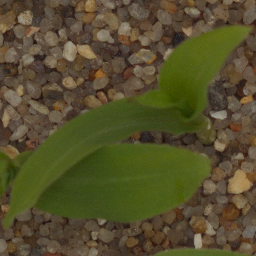

The shape of image to be predicted is:'(578, 578, 3)'
The shape of image to be predicted after expanding the dimensions is:'(1, 256, 256, 3)'


In [26]:
from google.colab.patches import cv2_imshow

img_pred = cv2.imread('/content/drive/MyDrive/AIML/Computer Vision/Predict.png')
img_pred_resize = cv2.resize(img_pred,(256,256), interpolation = cv2.INTER_CUBIC)
cv2_imshow(img_pred_resize)
img_predict = np.expand_dims(img_pred_resize, axis=0)
print(f"The shape of image to be predicted is:'{img_pred.shape}'")
print(f"The shape of image to be predicted after expanding the dimensions is:'{img_predict.shape}'")

**Encoding the Target Variable**

In [27]:
enc = LabelEncoder()
y = enc.fit_transform(classes)

num_classes = len(np.unique(y))
num_classes

12

**Splitting data into training and testing set**

training set : 70%

testing set: 30%

In [28]:
X_train, X_test, y_train, y_test = train_test_split(images, y, test_size=0.3, random_state=50)

**Creating validation set**

splitting test and validation sets each with 50% of data

In [29]:
random_seed = 2
X_test, X_val, y_test, y_val = train_test_split(X_test,y_test, test_size = 0.5, random_state=random_seed)

In [30]:
print(f"#### Shapes of Train, Test and Validation sets are: {X_train.shape},{X_test.shape},{X_val.shape}")

#### Shapes of Train, Test and Validation sets are: (3336, 256, 256, 3),(715, 256, 256, 3),(716, 256, 256, 3)


In [31]:
print(f"#### Shapes of Train, Test and Validation sets of Target are: {y_train.shape},{y_test.shape},{y_val.shape}")

#### Shapes of Train, Test and Validation sets of Target are: (3336,),(715,),(716,)


Now, we will move to the data modelling part, where we will train various models for image prediction.

# *Classification using Supervised Learning Techniques*

1. **Support Vector Machines**

Support Vector Machines(SVM) is considered to be a classification approach but it can be employed in both types of classification and regression problems. It can easily handle multiple continuous and categorical variables. SVM constructs a hyperplane in multidimensional space to separate different classes. SVM generates optimal hyperplane in an iterative manner, which is used to minimize an error. The core idea of SVM is to find a maximum marginal hyperplane(MMH) that best divides the dataset into classes.


How does SVM work for image classification?

The main objective is to segregate the given dataset in the best possible way. The distance between the either nearest points is known as the margin. The objective is to select a hyperplane with the maximum possible margin between support vectors in the given dataset. SVM searches for the maximum marginal hyperplane in the following steps:

- Generate hyperplanes that segregate the classes in the best way.

- Select the right hyperplane with the maximum segregation from the either nearest data points.

The dataset have over 65536 (256*256) features for each image and only 3336 images total in train dataset. To use an SVM, our model of choice, the number of features needs to be reduced.
PCA is a way of linearly transforming the data such that most of the information in the data is contained within a smaller number of features called components.

There is another method for SVM using CNNs. By adding the output layer as model.add(Dense(1,kernel_regularizer=l2(0.01),activation = "linear")) for binary classification and 

model.add(Dense(12,kernel_regularizer=l2(0.01),activation = "sigmoid")) for multiclass classification. PCA is not required for this method. We'll not focus on this method in this project.

For performing PCA for colored images, the images have to be flattened and then split into their red, green and blue channels. PCA is then applied to each channel, and finally these channels are again concatenated to 3 dimensions. 

In [32]:
def flatten(X):
  Xr, Xg, Xb = [],[],[]
  for samples in X:
    r, g, b = cv2.split(samples)
    Xr.append(r.flatten())
    Xg.append(g.flatten())
    Xb.append(b.flatten())
  Xr = np.array(Xr)
  Xg = np.array(Xg)
  Xb = np.array(Xb)
  return (Xr, Xg, Xb)

In [33]:
X_train_r, X_train_g, X_train_b = flatten(X_train)
X_test_r, X_test_g, X_test_b = flatten(X_test)
X_val_r, X_val_g, X_val_b = flatten(X_val)

Above, we can see that the images are split into r, g, b channels for all the train, test and validation datasets.

In [34]:
X_train_r.shape, X_train_g.shape, X_train_b.shape,
X_test_r.shape, X_test_g.shape, X_test_b.shape,
X_val_r.shape, X_val_g.shape, X_val_b.shape

((716, 65536), (716, 65536), (716, 65536))

For PCA, we have to specify the number of components to be considered. Here, out of 65536 components, we'll consider only 400 components.

In [35]:
n_components = 400
X_train_pca_r = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train_r)
X_train_pca_g = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train_g)
X_train_pca_b = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train_b)

X_test_pca_r = RandomizedPCA(n_components=n_components, whiten=True).fit(X_test_r)
X_test_pca_g = RandomizedPCA(n_components=n_components, whiten=True).fit(X_test_g)
X_test_pca_b = RandomizedPCA(n_components=n_components, whiten=True).fit(X_test_b)

X_val_pca_r = RandomizedPCA(n_components=n_components, whiten=True).fit(X_val_r)
X_val_pca_g = RandomizedPCA(n_components=n_components, whiten=True).fit(X_val_g)
X_val_pca_b = RandomizedPCA(n_components=n_components, whiten=True).fit(X_val_b)

In [36]:
Xr_train_pca = X_train_pca_r.transform(X_train_r)
Xg_train_pca = X_train_pca_g.transform(X_train_g)
Xb_train_pca = X_train_pca_b.transform(X_train_b)

Xr_test_pca = X_test_pca_r.transform(X_test_r)
Xg_test_pca = X_test_pca_g.transform(X_test_g)
Xb_test_pca = X_test_pca_b.transform(X_test_b)

Xr_val_pca = X_val_pca_r.transform(X_val_r)
Xg_val_pca = X_val_pca_g.transform(X_val_g)
Xb_val_pca = X_val_pca_b.transform(X_val_b)

After PCA, we'll now check the percentage of variance the train, test and validation data can explain by only using 500 components each.

In [37]:
X_train_pca_r.explained_variance_ratio_.sum(), X_train_pca_g.explained_variance_ratio_.sum(), X_train_pca_b.explained_variance_ratio_.sum(),
X_test_pca_r.explained_variance_ratio_.sum(), X_test_pca_g.explained_variance_ratio_.sum(), X_test_pca_b.explained_variance_ratio_.sum(),
X_val_pca_r.explained_variance_ratio_.sum(), X_val_pca_g.explained_variance_ratio_.sum(), X_val_pca_b.explained_variance_ratio_.sum()

(0.9253118849322386, 0.9612097034816511, 0.9490802380088657)

It is observed that the train data can explain 94.61% of variance in data, whereas test and validation can explain approximately 97% of variance by using only 500 components. This is truly amazing.

In [38]:
X_train_pca = np.concatenate([Xr_train_pca,Xg_train_pca,Xb_train_pca], axis=1)
X_test_pca = np.concatenate([Xr_test_pca,Xg_test_pca,Xb_test_pca], axis=1)
X_val_pca = np.concatenate([Xr_val_pca,Xg_val_pca,Xb_val_pca], axis=1)

After concatenating the r, g, b channels, the total number of components in train, test and validation are 1550 (500*3).

In [39]:
X_train_pca.shape, y_train.shape,
X_test_pca.shape, y_test.shape,
X_val_pca.shape, y_val.shape

((716, 1200), (716,))

- **Training the SVM Classifier Model**

Now, it's time to train the SVM Classifier. We'll use GridSearchCV() of SKLearn library. This function helps to loop through predefined hyperparameters and fit the estimator (model) on the training set. We have defined a set of hyperparameters for 'C', 'kernel', and 'gamma' in param_grid.

In [40]:
param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]
svc = SVC()
clf = GridSearchCV(svc, param_grid, verbose=10, n_jobs=-1)
clf.fit(X_train_pca, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
                         {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']}],
             verbose=10)

In [41]:
X_train.shape[0]

3336

In [42]:
y_train.shape[0]

3336

In [43]:
svm_score = clf.score(X_val_pca, y_val)

In [44]:
y_pred = clf.predict(X_test_pca)
svm_accuracy = metrics.accuracy_score(y_test, y_pred)

**Prediction using SVM**

We will perform PCA for the test image as well following the same procedure as we did for training data.

In [45]:
pred_img = np.squeeze(img_predict, axis=0)
X_pred_r, X_pred_g, X_pred_b = cv2.split(pred_img)

In [46]:
X_pred_pca_r = X_train_pca_r.transform(np.expand_dims(X_pred_r.flatten(), axis=0))
X_pred_pca_g = X_train_pca_g.transform(np.expand_dims(X_pred_g.flatten(), axis=0))
X_pred_pca_b = X_train_pca_b.transform(np.expand_dims(X_pred_b.flatten(), axis=0))

X_pred_pca = np.concatenate([X_pred_pca_r,X_pred_pca_g,X_pred_pca_b], axis=1)

We'll now predict the unseen image using the SVM Classifier trained model. 

In [47]:
pred_svm = clf.predict(X_pred_pca)[0]

print(f"The predicted label is:'{pred_svm}'")

The predicted label is:'7'


The model predict the image as class '7'.

In [48]:
model_performance = model_performance.append({'Model':'SVM',
                                              'Accuracy': svm_accuracy,
                                              'Loss': 'NA',
                                              'Predicted Class': pred_svm                                      
                                              }, ignore_index=True)

model_performance

,Model,Accuracy,Loss,Predicted Class
0,SVM,0.19021,NA,7


The SVM Classifier model is able to predict with an accuracy of only 19% approx.

2. **Random Forest**

Random forest, as its name implies, consists of a large number of individual decision trees that operate as an ensemble. Each individual tree in the random forest declares a class prediction and the class with the most votes becomes the model’s prediction. 

- **Training the RF Classifier Model**

For Random Forest algorithm, the hyperparameters chosen are 'n_estimators', 'min_samples_leaf', and are defined in param_grid.

In [49]:
param_grid=[
            {'n_estimators':[100,200],
             'min_samples_leaf':[2,3]}
           ]
rf = RandomForestClassifier()
clf = GridSearchCV(rf, param_grid, verbose=10, n_jobs=-1)
clf.fit(X_train_pca,y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid=[{'min_samples_leaf': [2, 3],
                          'n_estimators': [100, 200]}],
             verbose=10)

- **Predicting using RF Classifier Model**

In [50]:
rf_score = clf.score(X_val_pca, y_val)
y_pred = clf.predict(X_test_pca)
rf_accuracy = metrics.accuracy_score(y_test, y_pred)
pred_rf = clf.predict(X_pred_pca)[0]
print(f"The predicted label is:'{pred_rf}'")

The predicted label is:'1'


The RF Classifier model predicts the test image as class '1'.

In [51]:
model_performance = model_performance.append({'Model':'RF',
                                              'Accuracy': rf_accuracy,
                                              'Loss': 'NA',
                                              'Predicted Class': pred_rf                                      
                                              }, ignore_index=True)

model_performance

,Model,Accuracy,Loss,Predicted Class
0,SVM,0.19021,NA,7
1,RF,0.25035,NA,1


The RF Classifier model has an accuracy greater than the SVM Classifier model.

 **3. Decision Tree**

 Decision Tree is a Supervised learning technique that can be used for both classification and Regression problems, but mostly it is preferred for solving Classification problems. It is a tree-structured classifier, where internal nodes represent the features of a dataset, branches represent the decision rules and each leaf node represents the outcome.

In a Decision tree, there are two nodes, which are the Decision Node and Leaf Node. Decision nodes are used to make any decision and have multiple branches, whereas Leaf nodes are the output of those decisions and do not contain any further branches.

The decisions are performed on the basis of features of the given dataset.

- **Training the DT Classifier Model**

For Decision Trees algorithm, the hyperparameters chosen are 'max_leaf_nodes', 'min_samples_split', and are defined in param_grid.

In [52]:
from sklearn.tree import DecisionTreeClassifier
param_grid = [
              {'max_leaf_nodes': list(range(2, 100)), 
               'min_samples_split': [2, 3, 4]}
              ]
dt = DecisionTreeClassifier()
clf = GridSearchCV(dt, param_grid, verbose=10, n_jobs=-1)
clf.fit(X_train_pca,y_train)

Fitting 5 folds for each of 294 candidates, totalling 1470 fits


GridSearchCV(estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid=[{'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                             13, 14, 15, 16, 17, 18, 19, 20, 21,
                                             22, 23, 24, 25, 26, 27, 28, 29, 30,
                                             31, ...],
                          'min_samples_split': [2, 3, 4]}],
             verbose=10)

In [53]:
dt_score = clf.score(X_val_pca, y_val)
y_pred = clf.predict(X_test_pca)
dt_accuracy = metrics.accuracy_score(y_test, y_pred)
pred_dt = clf.predict(X_pred_pca)[0]
print(f"The predicted label is:'{pred_dt}'")

The predicted label is:'1'


The DT Classifier model predicts the unseen image as class '1'.

In [54]:
model_performance = model_performance.append({'Model':'DT',
                                              'Accuracy': dt_accuracy,
                                              'Loss': 'NA',
                                              'Predicted Class': pred_dt                                      
                                              }, ignore_index=True)

model_performance

,Model,Accuracy,Loss,Predicted Class
0,SVM,0.190210,NA,7
1,RF,0.250350,NA,1
2,DT,0.127273,NA,1


The DT Classifier model is able to predict images with an accuracy of only 26% approximately.

# *Classification using Artificial Neural Network (ANN)*

Artificial neural networks are built like the human brain, with neuron nodes interconnected like a web. The human brain has hundreds of billions of cells called neurons. Each neuron is made up of a cell body that is responsible for processing information by carrying information towards (inputs) and away (outputs) from the brain.


An ANN has hundreds or thousands of artificial neurons called processing units, which are interconnected by nodes. These processing units are made up of input and output units. The input units receive various forms and structures of information based on an internal weighting system, and the neural network attempts to learn about the information presented to produce one output report. Just like humans need rules and guidelines to come up with a result or output, ANNs also use a set of learning rules called backpropagation, an abbreviation for backward propagation of error, to perfect their output results.


An ANN initially goes through a training phase where it learns to recognize patterns in data, whether visually, aurally, or textually. During this supervised phase, the network compares its actual output produced with what it was meant to produce—the desired output. The difference between both outcomes is adjusted using backpropagation. This means that the network works backward, going from the output unit to the input units to adjust the weight of its connections between the units until the difference between the actual and desired outcome produces the lowest possible error.

To begin with ANN, let's first import the necessary libraries.

In [55]:
import itertools

import tensorflow
from tensorflow.keras.layers import Dense, Dropout, InputLayer, BatchNormalization, Flatten
from tensorflow.keras.layers import GlobalAveragePooling2D, Conv2D, MaxPool2D, GlobalMaxPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalMaxPooling2D
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

We'll encode the label names / classes using LabelBinarizer() function which encodes the actual class as 1 and rest of the classes as 0.

In [56]:
from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y2 = enc.fit_transform(classes)

The following is an output of the LabelBinarizer().

In [57]:
y2[0]

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0])

Next, we'll split the data into train, test and validation sets.

In [58]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, y2, test_size=0.3, random_state=50)

In [59]:
random_seed = 2
from sklearn.model_selection import train_test_split
X_test, X_val, y_test, y_val = train_test_split(X_test,y_test, test_size = 0.5, random_state=random_seed)

Now, let's check the shapes of features and target.

In [60]:
X_train.shape,y_train.shape

((3336, 256, 256, 3), (3336, 12))

It is obvious that the features are colored images with 3 channels having width and height dimensions of 256 each, and the target is the label.

In [61]:
num_classes = len(np.unique(y_train))
num_classes

2

The num_classes are the number of unique classes. As we used LabelBinarizer(), the unique classes are 0 and 1. Hence, the value of num_classes variable is 2. This will be used as the output dimension of the ANN model.

- **Training the ANN Classifier Model**

We will create a simple ANN Classifier model with few dense and dropout layers. We have used 'relu' as the activation function for all the input dense layers. The activation function of the output dense layer is 'softmax'. The optimizer of the model is 'Adam' with a learning rate of 0.000001.

In [62]:
def ann_model(height, width, num_channels, num_classes, loss='categorical_crossentropy', metrics=['accuracy']):
  # batch_size = None

  model = Sequential()

  model.add(InputLayer(input_shape=(height, width, num_channels)))

  model.add(Flatten())
  model.add(BatchNormalization())
  model.add(Dense(1024, activation='relu'))
  model.add(Dropout(0.2))

  model.add(BatchNormalization())
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.2))

  model.add(BatchNormalization())
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.2))

  model.add(BatchNormalization())
  model.add(Dense(num_classes, activation = "softmax"))
  opt = tensorflow.keras.optimizers.Adam(lr=0.000001)
  model.compile(optimizer = opt, loss = loss, metrics = metrics)

  model.summary()
  return model

The inputs to the 'ann_model' model is the dimension of the features and target.

In [63]:
ann = ann_model(256,256,3,12)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 196608)            0         
                                                                 
 batch_normalization (BatchN  (None, 196608)           786432    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 1024)              201327616 
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 batch_normalization_1 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 512)               5

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Next, we'll train the ann model with train data and validate the model using validation data. We have set the number of epochs as 50.

In [64]:
history = ann.fit(X_train, 
                  y_train, 
                  epochs = 50, 
                  validation_data = (X_val,y_val))

Epoch 1/50
105/105 [==============================] - 17s 122ms/step - loss: 2.7703 - accuracy: 0.1688 - val_loss: 2.0988 - val_accuracy: 0.2975
Epoch 2/50
105/105 [==============================] - 12s 118ms/step - loss: 2.1232 - accuracy: 0.3189 - val_loss: 1.7151 - val_accuracy: 0.4176
Epoch 3/50
105/105 [==============================] - 12s 118ms/step - loss: 1.8167 - accuracy: 0.3882 - val_loss: 1.5475 - val_accuracy: 0.4888
Epoch 4/50
105/105 [==============================] - 12s 118ms/step - loss: 1.6867 - accuracy: 0.4245 - val_loss: 1.4430 - val_accuracy: 0.5377
Epoch 5/50
105/105 [==============================] - 12s 118ms/step - loss: 1.5401 - accuracy: 0.4838 - val_loss: 1.3764 - val_accuracy: 0.5698
Epoch 6/50
105/105 [==============================] - 12s 118ms/step - loss: 1.4342 - accuracy: 0.5093 - val_loss: 1.3171 - val_accuracy: 0.5782
Epoch 7/50
105/105 [==============================] - 12s 117ms/step - loss: 1.3363 - accuracy: 0.5441 - val_loss: 1.2804 - val_ac

- **Evaluating the ANN Classifier Model**

In [65]:
ann_loss, ann_accuracy = ann.evaluate(X_test, y_test, verbose=1)
print('Test loss:', ann_loss)
print('Test accuracy:', ann_accuracy)

23/23 [==============================] - 1s 28ms/step - loss: 1.0478 - accuracy: 0.6615
Test loss: 1.0477746725082397
Test accuracy: 0.6615384817123413


The ANN model has an accuracy of 66% approximately on unseen images. Now, we'll visualize the training loss vs validation loss and Training accuracy vs validation accuracy.

**Model Evaluation**

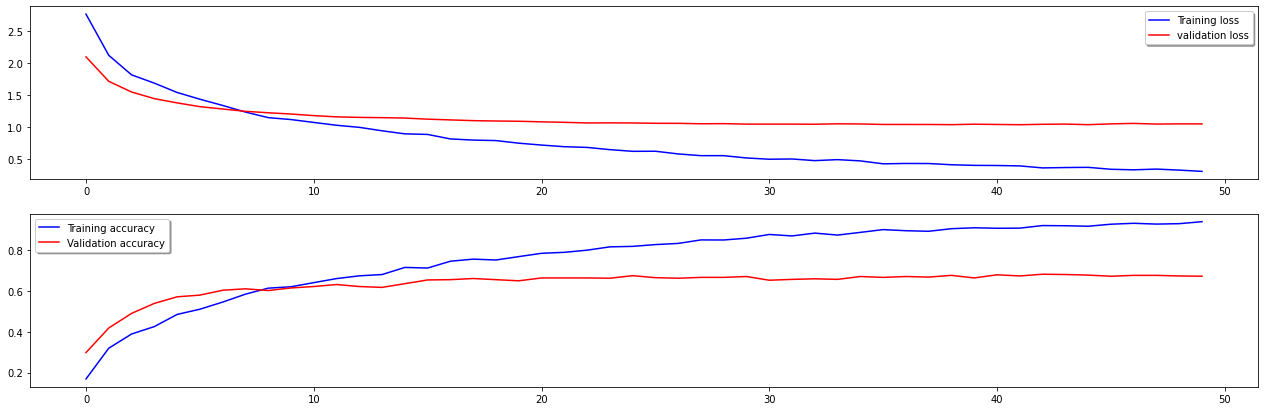

In [66]:
fig, ax = plt.subplots(2,1 , figsize=(22,7))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In the next step, we'll plot the confusion matrix which displays the number of correct and false predictions for all the classes.

**Confusion Matrix**

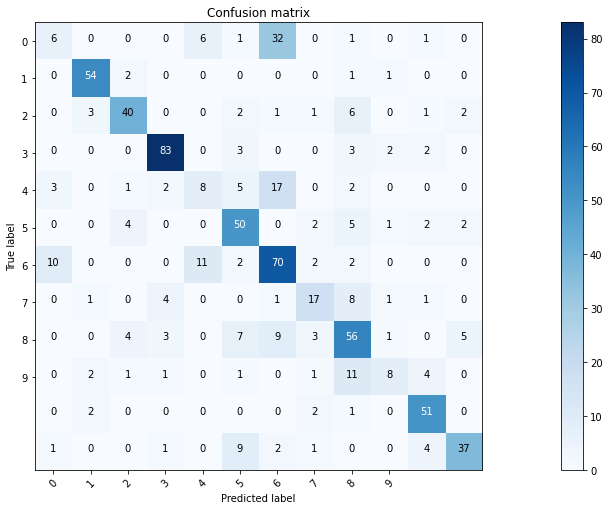

In [67]:
from sklearn.metrics import confusion_matrix
import itertools
plt.subplots(figsize=(22,7)) #set the size of the plot 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
y_pred = ann.predict(X_val)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred,axis = 1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))

- **Predicting using ANN Classifier Model**

In [68]:
ann_predict = np.argmax(ann.predict(img_predict))

In [69]:
print('The predicted flower is with label:', ann_predict)

The predicted flower is with label: 1


- **The ANN Classifier model predicts the test image as class '1'.**

In [70]:
model_performance = model_performance.append({'Model':'ANN',
                                              'Accuracy': ann_accuracy,
                                              'Loss': ann_loss,
                                              'Predicted Class': ann_predict                                      
                                              }, ignore_index=True)

model_performance

,Model,Accuracy,Loss,Predicted Class
0,SVM,0.190210,NA,7
1,RF,0.250350,NA,1
2,DT,0.127273,NA,1
3,ANN,0.661538,1.047775,1


The ANN model has an accuracy of 0.64 approximately and loss of 1.16 approximately. The loss is high. It can be reduced by modifying the ANN model by adding more dense layers and neurons. We can also try various learning rates of the optimizer.

# *Classification using Convolution Neural Network (CNN)*

A Convolutional Neural Network (ConvNet/CNN) is a Deep Learning algorithm which can take in an input image, assign importance (learnable weights and biases) to various aspects/objects in the image and be able to differentiate one from the other. The pre-processing required in a ConvNet is much lower as compared to other classification algorithms. While in primitive methods filters are hand-engineered, with enough training, ConvNets have the ability to learn these filters/characteristics.

The objective of the Convolution Operation is to extract the high-level features such as edges, from the input image. ConvNets need not be limited to only one Convolutional Layer. Conventionally, the first ConvLayer is responsible for capturing the Low-Level features such as edges, color, gradient orientation, etc. With added layers, the architecture adapts to the High-Level features as well, giving us a network which has the wholesome understanding of images in the dataset, similar to how we would.

- **Training the CNN Classifier Model**

Unlike ANNs, in CNNs we will use Conv2D and MaxPool2D layers along with padding, strides and batch inputs. The optimizer for this CNN model is RMSprop with learning rate as '0.001'. 

In [71]:
def cnn_model(height, width, num_channels, num_classes, loss='categorical_crossentropy', metrics=['accuracy']):
  batch_size = None

  model = Sequential()

  model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                  activation ='relu', batch_input_shape = (batch_size,height, width, num_channels)))


  model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                  activation ='relu'))
  model.add(MaxPool2D(pool_size=(2,2)))
  model.add(Dropout(0.2))


  model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'same', 
                  activation ='relu'))
  model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
  model.add(Dropout(0.3))

  model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
  model.add(Dropout(0.4))



  model.add(GlobalMaxPooling2D())
  model.add(Dense(256, activation = "relu"))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation = "softmax"))

  optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
  model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
  model.summary()
  return model

The inputs to the 'cnn_model' model is the dimension of the features and target.

In [72]:
cnn = cnn_model(256,256,3,12)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 dropout_3 (Dropout)         (None, 128, 128, 32)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 64)      36928     
                                                      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Next, we'll train the CNN model with train data and validate the model using validation data. We have set the number of epochs as 50.

In [73]:
history = cnn.fit(X_train, 
                  y_train, 
                  epochs = 50, 
                  validation_data = (X_val,y_val))

Epoch 1/50
105/105 [==============================] - 64s 478ms/step - loss: 2.7821 - accuracy: 0.1412 - val_loss: 2.3706 - val_accuracy: 0.2221
Epoch 2/50
105/105 [==============================] - 46s 439ms/step - loss: 2.2779 - accuracy: 0.2200 - val_loss: 2.2234 - val_accuracy: 0.2570
Epoch 3/50
105/105 [==============================] - 46s 438ms/step - loss: 2.0675 - accuracy: 0.2638 - val_loss: 2.0357 - val_accuracy: 0.2360
Epoch 4/50
105/105 [==============================] - 46s 438ms/step - loss: 1.9726 - accuracy: 0.2764 - val_loss: 1.9514 - val_accuracy: 0.2556
Epoch 5/50
105/105 [==============================] - 46s 437ms/step - loss: 1.8731 - accuracy: 0.3339 - val_loss: 1.8525 - val_accuracy: 0.3617
Epoch 6/50
105/105 [==============================] - 46s 438ms/step - loss: 1.7956 - accuracy: 0.3726 - val_loss: 1.7890 - val_accuracy: 0.3436
Epoch 7/50
105/105 [==============================] - 46s 437ms/step - loss: 1.6633 - accuracy: 0.4209 - val_loss: 1.5439 - val_ac

- **Evaluating the CNN Classifier Model**

In [74]:
cnn_loss, cnn_accuracy = cnn.evaluate(X_test, y_test, verbose=1)
print('Test loss:', cnn_loss)
print('Test accuracy:', cnn_accuracy)

23/23 [==============================] - 5s 200ms/step - loss: 0.8569 - accuracy: 0.7329
Test loss: 0.8568825721740723
Test accuracy: 0.7328671216964722


- **Predicting using CNN Classifier Model**

In [75]:
cnn_predict = np.argmax(cnn.predict(img_predict))

In [76]:
model_performance = model_performance.append({'Model':'CNN',
                                              'Accuracy': cnn_accuracy,
                                              'Loss': cnn_loss,
                                              'Predicted Class': cnn_predict                                      
                                              }, ignore_index=True)

model_performance

,Model,Accuracy,Loss,Predicted Class
0,SVM,0.190210,NA,7
1,RF,0.250350,NA,1
2,DT,0.127273,NA,1
3,ANN,0.661538,1.047775,1
4,CNN,0.732867,0.856883,1


The CNN Classifier model predicts the test image as class '7' and has a better accuracy and lesser loss than ANN model. In the next section, we will perform some data augmentation techniques to the CNN model and see if it outperforms all the models.

# Classification using Convolution Neural Network (CNN) with Data Augmentation

The ImageDataGenerator() from Keras provides a quick and easy way to augment your images. It provides a host of different augmentation techniques like standardization, rotation, shifts, flips, brightness change, and many more.


However, the main benefit of using the Keras ImageDataGenerator class is that it is designed to provide real-time data augmentation. Meaning it is generating augmented images on the fly while your model is still in the training stage.

ImageDataGenerator class ensures that the model receives new variations of the images at each epoch. But it only returns the transformed images and does not add it to the original corpus of images. If it was, in fact, the case, then the model would be seeing the original images multiple times which would definitely overfit our model.


Another advantage of ImageDataGenerator is that it requires lower memory usage. This is so because without using this class, we load all the images at once. But on using it, we are loading the images in batches which saves a lot of memory.

In [ ]:
# With data augmentation to prevent overfitting

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

ReduceLROnPlateau() from keras.callbacks library is used to reduce learning rate when a metric has stopped improving. Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates. This scheduler reads a metrics quantity and if no improvement is seen for a ‘patience’ number of epochs, the learning rate is reduced.

In [ ]:
from keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
epochs = 30
batch_size = 38

We will use the augmented data to train the CNN model and with the callback using ReduceLROnPlateau().

In [ ]:
# X_train, X_test, y_train, y_test
history = cnn.fit(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

- **Evaluating the CNN Classifier Model - with Data Augmentation**

In [ ]:
cnn_loss_aug, cnn_accuracy_aug = cnn.evaluate(X_test, y_test, verbose=1)
print('Test loss:', cnn_loss_aug)
print('Test accuracy:', cnn_accuracy_aug)

**Model Evaluation**<br>
Now, we'll visualize the training loss vs validation loss and Training accuracy vs validation accuracy of the CNN model with augmented data.|

In [ ]:
fig, ax = plt.subplots(2,1 , figsize=(22,7))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

**Confusion Matrix** - which displays the number of correct and false predictions for all the classes.

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
plt.subplots(figsize=(22,7)) #set the size of the plot 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))

- **Predicting using CNN Classifier Model with Data Augmentation**

In [ ]:
cnn_predict_aug = np.argmax(cnn.predict(img_predict))

In [ ]:
print('The predicted flower is with label:', cnn_predict)

The CNN Classifier model with augmented data predicts the test image as class '7'.

In [ ]:
model_performance = model_performance.append({'Model':'CNN with Data Augmentaion',
                                              'Accuracy': cnn_accuracy_aug,
                                              'Loss': cnn_loss_aug,
                                              'Predicted Class': cnn_predict_aug                                      
                                              }, ignore_index=True)

model_performance

Thus using augmented images, the CNN model has a better accuracy of 81% approximately and with a lesser loss than CNN without data augmentation.

Since, the CNN model with augmented data has a better performance than all the models, we'll save this model.

**Saving the best model**

In [ ]:
model.save("CNN_PlantSeedling_ImageClassification.h5")

# **Conclusion**

Convolution Neural Networks outperforms Neural Networks and which in turn out perform Supervised Learning models. 

The best part of CNNs is high accuracy of image prediction and less loss. Also, we do not have to do feature extraction. The system learns to do feature extraction and the core concept of CNN is, it uses convolution of image and filters to generate invariant features which are passed on to the next layer. The features in the next layer are convoluted with different filters to generate more invariant and abstract features and the process continues till one gets final feature / output which is invariant to occlusions.
ANNs are better than Supervised Learning models because we don't have to perform feature extraction in ANNS whereas in Supervised Learning, we must perform the Principal component analysis (PCA) to compute the principal components in images. 

In predicting the Plant Seedlings dataset, we can see that the accuracy of Support Vector Machines, Random Forest and Decision Tree models are less than 45%. Using ANNs, the accuracy increased to 65%. This was improved much more by using CNNs. The accuracy increased to approximately 76% with less loss. CNNs with Data Augmentation outperformed all the models. It has the highest accuracy of 81% and with the least loss of 58%. 